In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 100
import matplotlib.gridspec as gridspec
import tensorflow as tf
from tensorflow.keras.models import load_model


2024-12-06 21:16:51.877167: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-06 21:16:51.996822: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/icecube.opensciencegrid.org/py3-v4.2.1/../distrib/OpenCL_Linux/lib/x86_64:/cvmfs/icecube.opensciencegrid.org/py3-v4.2.1/Ubuntu_20.04_x86_64/lib:/cvmfs/icecube.opensciencegrid.org/py3-v4.2.1/Ubuntu_20.04_x86_64/lib64
2024-12-06 21:16:51.996847: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-12-06 21:16:52.017701: E

In [3]:
import os

ABS_PATH_HERE = str(os.getcwd())

In [4]:
## Function to normalize the traces to feed to the networks. Saves the normalizing factor
def Normalize(array):
    normalized_array = np.zeros_like(array)  # Create a new array to store normalized values
    scale_fac = []
    for i in range(array.shape[0]):  # Iterate over samples/events
        max_value = np.max(np.abs(array[i]))  # Calculate the maximum value across both channels
        
        if max_value != 0:  # Avoid division by zero
            normalized_sample = array[i] / max_value
            normalized_array[i] = normalized_sample
        else:
            print("Max value 0 encountered at index :", i)
        scale_fac.append(max_value)
    return normalized_array, scale_fac


## Function to get Network output of Classifier 
def GetOutput(Traces, Classifier): 
    Traces = np.array(Traces)
    predict = Classifier.predict(Traces)
    y_predict = predict.reshape(predict.shape[0],)
    return y_predict

In [5]:
# model_Denoiser = "/home/arehman/work/Validation_dataV7/models/ant1_fil64_ks33.h5"
model_Denoiser = ABS_PATH_HERE + "/models/ant1_denoiser.h5"
model_Classifier = ABS_PATH_HERE + "/models/ant1_classifier.h5"


## Data Dir
DataDir = ABS_PATH_HERE + "/data/"

In [6]:
## Load Data
SigPlusNoise = np.load(DataDir + "SigPlusNoise.npy")
PureSignals = np.load(DataDir + "PureSignals.npy")

In [7]:
print(f"No. of Signal traces in dataset = {len(PureSignals)} and Noisy traces = {len(SigPlusNoise)}")

No. of Signal traces in dataset = 1202 and Noisy traces = 1202


In [9]:
## Normalizing

SigPlusNoise, SFactor_SigPlusNoise = Normalize(SigPlusNoise)

## Loading the classifier model

Classifier = load_model(model_Classifier, compile=False)

## Getting model predictions
sig_out = GetOutput(SigPlusNoise, Classifier)

2024-12-06 20:20:49.339328: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/icecube.opensciencegrid.org/py3-v4.2.1/../distrib/OpenCL_Linux/lib/x86_64:/cvmfs/icecube.opensciencegrid.org/py3-v4.2.1/Ubuntu_20.04_x86_64/lib:/cvmfs/icecube.opensciencegrid.org/py3-v4.2.1/Ubuntu_20.04_x86_64/lib64
2024-12-06 20:20:49.339362: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2024-12-06 20:20:49.339381: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-arehman): /proc/driver/nvidia/version does not exist
2024-12-06 20:20:49.339576: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in p

38/38 [==============================] - 2s 33ms/step


In [10]:
### Loading the model and getting model predictions
Denoiser = load_model(model_Denoiser, compile=False)
## Predicting
DenoisedWaveforms = Denoiser.predict(SigPlusNoise)

## Rescaling the traces 
NoisyTraces = np.array([SigPlusNoise[i] * SFactor_SigPlusNoise[i] for i in range(len(SigPlusNoise))])
DenoisedTraces = np.array([DenoisedWaveforms[i] * SFactor_SigPlusNoise[i] for i in range(len(DenoisedWaveforms))])

38/38 [==============================] - 9s 235ms/step


# Make Plots:

In [42]:
def GetSpectra(trace):
    fft_result = np.fft.fft(trace)
    n = len(trace)
    Spec = np.abs(fft_result[:n//2])

    return np.array(Spec)

def MakePlot(Noisy, Denoised, Pure, Class_score, index=2, ylim=0.3, y_text=0.115):
    
    ## Ch 0
    noisy = Noisy[index][:, 0]/1e-12
    denoised = Denoised[index][:, 0]/1e-12
    pure = Pure[index][:, 0]/1e-12
    
    lfs = 11 # labels font size
    
    fig = plt.figure(figsize=(13,4.5))
    plt.subplots_adjust(wspace=0.17) 
    plt.subplots_adjust(hspace=0.06)
    
    ax = fig.add_subplot(221)

    score = Class_score[index]
    
    ax.set_title(f"Classifier Score = {score}")
    ax.plot(noisy, c='skyblue',  lw=0.8,  alpha=1.0)

    
    ax.plot(denoised,c='red',    lw=1.2,  alpha=0.7)
    ax.plot(pure,"--",c='black', lw=0.8,  alpha=0.7)

    
    plt.ylabel("Amp [mV]", fontsize=lfs)
    ax.set_xlim( 0, 1000 )
    ax.set_ylim( -ylim, ylim )
    
    ax.tick_params(axis='both', which='both', direction='in',labelsize=11);
    
    frame1 = plt.gca()
    frame1.axes.xaxis.set_ticklabels([])
    
    
    ax = fig.add_subplot(222)
    frame1 = plt.gca()
    frame1.axes.xaxis.set_ticklabels([])
    
    ax.plot( GetSpectra(noisy), c='skyblue',  lw=1.2,  alpha=1,   label="Noisy")
    ax.plot( GetSpectra(denoised), c='red',   lw=1.2,  alpha=0.7, label="Denoised")
    ax.plot( GetSpectra(pure),"--", c='black', lw=1.2, alpha=0.7, label="True")
    ax.legend(loc="best", ncol = 3, columnspacing=0.3, fontsize=9)

    ax.tick_params(axis='both', which='both', direction='in',labelsize=11);
    
    plt.yscale('log')
    plt.ylabel("Amp [mV/MHz]", fontsize=lfs)
    
    ax.set_xlim( 40, 370 )
    ax.set_ylim( 1e-3, 1e2 )
    
    
    ##### For Channel 1
    noisy = Noisy[index][:, 1]/1e-12
    denoised = Denoised[index][:, 1]/1e-12
    pure = Pure[index][:, 1]/1e-12
        
    ax = fig.add_subplot(223)
    ax.plot(noisy, c='skyblue',  lw=0.8,  alpha=1.0)
    ax.plot(denoised,c='red',    lw=1.2,  alpha=0.7)
    ax.plot(pure,"--",c='black', lw=0.8,  alpha=0.7)

    plt.ylabel("Amp [mV]", fontsize=lfs)
    plt.xlabel("Times [ns]", fontsize=lfs)
    ax.set_xlim( 0, 1000 )
    ax.set_ylim( -ylim, ylim )
    
    ax.tick_params(axis='both', which='both', direction='in',labelsize=11);
    
    
    ax = fig.add_subplot(224)
    ax.plot( GetSpectra(noisy), c='skyblue',  lw=1.2,  alpha=1,   label="Noisy")
    ax.plot( GetSpectra(denoised), c='red',   lw=1.2,  alpha=0.7, label="Denoised")
    ax.plot( GetSpectra(pure),"--", c='black', lw=1.2, alpha=0.7, label="True")
    
    plt.yscale('log')
    plt.ylabel("Amp [mV/MHz]", fontsize=lfs)
    plt.xlabel("Freqs [MHz]", fontsize=lfs)
    ax.tick_params(axis='both', which='both', direction='in',labelsize=11);
    
    ax.set_xlim( 40, 370 )
    ax.set_ylim( 1e-3, 1e2 )



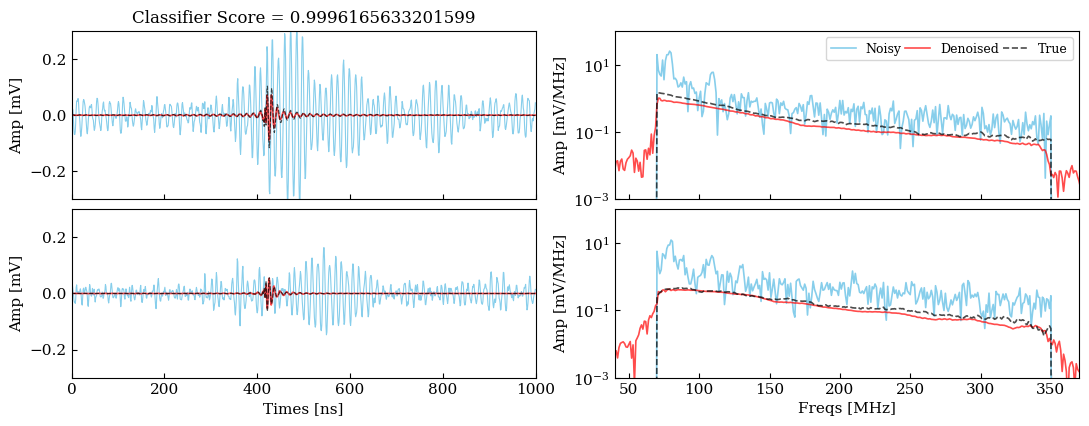

In [61]:
ii = 20

MakePlot(NoisyTraces, DenoisedTraces, PureSignals, sig_out, index=ii)